In [525]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import torch
from torchvision import datasets, transforms
from PIL import Image
import random

In [526]:
data_path = "SkinData/data/alex_axolotls/"

In [527]:
class RGBADataset(torch.utils.data.Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform
        self.image_paths = [os.path.join(root, f) for f in os.listdir(root) if os.path.isfile(os.path.join(root, f))]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert("RGBA")
        if self.transform:
            image = self.transform(image)
        return image

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

In [528]:
dataset = RGBADataset(root=data_path, transform=transform)
print(len(dataset))

77


In [529]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class DiffusionModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(DiffusionModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x

In [530]:
num_samples = min(10, len(dataset))
subset_indices = random.sample(range(len(dataset)), num_samples)
sampling_dataset = [dataset[i] for i in subset_indices]
print(subset_indices)
print(len(sampling_dataset))

dataloader = torch.utils.data.DataLoader(sampling_dataset)

# モデルのインスタンス化
input_dim = 64 * 64 * 4  # 64x64のRGBA画像
model = DiffusionModel(input_dim=input_dim, hidden_dim=4, output_dim=input_dim)

# GPUが利用可能な場合はGPUに転送
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# 損失関数とオプティマイザの定義
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

[9, 48, 66, 47, 71, 59, 23, 10, 52, 40]
10


In [531]:
num_epochs = 1000
for epoch in range(num_epochs):
    for data in dataloader:
        images = data
        images = images.view(images.size(0), -1)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()
    print(f"\rEpoch {epoch+1}/{num_epochs}, Loss: {loss.item()}",end="")

Epoch 1000/1000, Loss: 0.03658725693821907

In [532]:
generated_images = model(torch.randn(1, input_dim))
generated_images = generated_images.view(4, 64, 64).detach().numpy()
image_array_scaled = (np.transpose(generated_images, (1, 2, 0)) * 255).astype(np.uint8)
img = cv2.cvtColor(image_array_scaled, cv2.COLOR_RGB2BGRA)

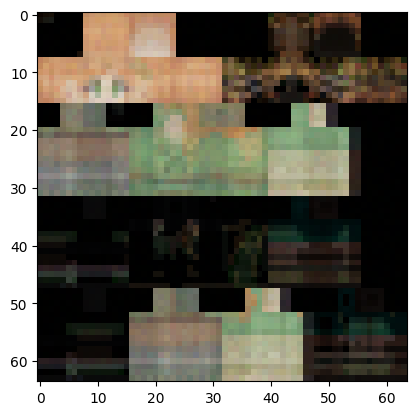

In [535]:
h, w = img.shape[:2]
sum_alpha = 0
for i in range(h):
    for j in range(w):
        b, g, r, a = img[i, j]
        if a <= 80:
            a = 0
        img[i,j] = [b,g,r,a]
        sum_alpha += a
        # if (int(b)+int(g)+int(r) <= 190) and ((32<= j and i <= 15) or (32 <= i <= 47) or (j <= 15 and 48 <= i) or (46 <= j and 48 <= i)):
            # img[i,j] = [0,0,0,0]
        # elif ((32<= j and i <= 15) or (32 <= i <= 47) or (j <= 15 and 48 <= i) or (46 <= j and 48 <= i)):
            # num = 20
            # img[i,j] = [min(255,b+(num+b//2)), min(255,g+(num+g//2)), min(255,r+(num+r//2)), 255]
            # _b, _g, _r, _a = img[i, j]
            # if int(_b)+int(_g)+int(r) <= 250:
            #     img[i,j] = [0,0,0,0]

if sum_alpha >= 500000:
    print("akan")
dir_path = "Created_Skin/"
files = os.listdir(dir_path)
cv2.imwrite(f'{dir_path}ai_{len(files)+1}.png', img)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGRA2RGB))
plt.show()